In [488]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Phase 1: Data Preparation & RFM Feature Engineering

### What I Did:
- Loaded and cleaned raw transaction data from `Transactions.csv` and `Categories.csv`
- Calculated three key metrics for each customer:
  - **Recency**: Days since last purchase
  - **Frequency**: Total number of purchases
  - **Monetary**: Total amount spent

### Techniques Used:
- Feature engineering using `groupby` and aggregation
- Data cleaning (null handling, column renaming)
- Modularized the preprocessing into reusable Python scripts (`scripts/preprocessing.py`)

### Output:
- Saved a clean, customer-level RFM table to `data/processed/rfm_table.csv`

### Key Insights:
- Customers vary significantly in recency, frequency, and spend behavior
- Most customers are low-frequency, low-spend buyers — highlighting the need for segmentation

---

### 1a. **RFM Table Overview**

- **Shape of RFM Table**: `(13,521 rows × 4 columns)`
- Each row represents a unique **CustomerID**
- Columns:
  - `Recency`: Days since the customer’s last transaction
  - `Frequency`: Number of purchases made
  - `Monetary`: Total amount spent by the customer

#### Sample Rows:
| CustomerID | Recency | Frequency | Monetary |
|------------|---------|-----------|----------|
| 0          | 407     | 1         | 70.0     |
| 1          | 23      | 1         | 153.6    |
| 2          | 300     | 1         | 238.8    |
| 3          | 137     | 2         | 986.0    |
| 4          | 20      | 4         | 1224.6   |

### Observations:
- Customers show wide variation in:
  - **Recency** (some transacted recently, others haven’t in 400+ days)
  - **Monetary** (spending ranges from small amounts to over 1200)
  - **Frequency** is skewed — most customers are one-time buyers
- This confirms the need for **clustering** — behavior is too diverse for a single marketing approach

In [489]:
# Load the RFM table
rfm = pd.read_csv('../data/processed/rfm_table.csv')

# Preview the structure
print("Shape of RFM data:", rfm.shape)
rfm.head()

Shape of RFM data: (13521, 6)


,CustomerID,Recency,Monetary,Frequency,Cluster,Segment
0,0,407,70.0,1,0,At-Risk
1,1,23,153.6,1,1,Recent Low-Spenders
2,2,300,238.8,1,0,At-Risk
3,3,137,986.0,2,1,Recent Low-Spenders
4,4,20,1224.6,4,3,Loyal Customers


---

### 1b. **RFM Distribution**
**File:** `visualize_distribution_rfm.png`

- **Recency**: Right-skewed — most customers purchased recently.
- **Frequency**: Extremely skewed — majority are one-time buyers.
- **Monetary**: A small number of customers contribute significantly to revenue (VIPs).

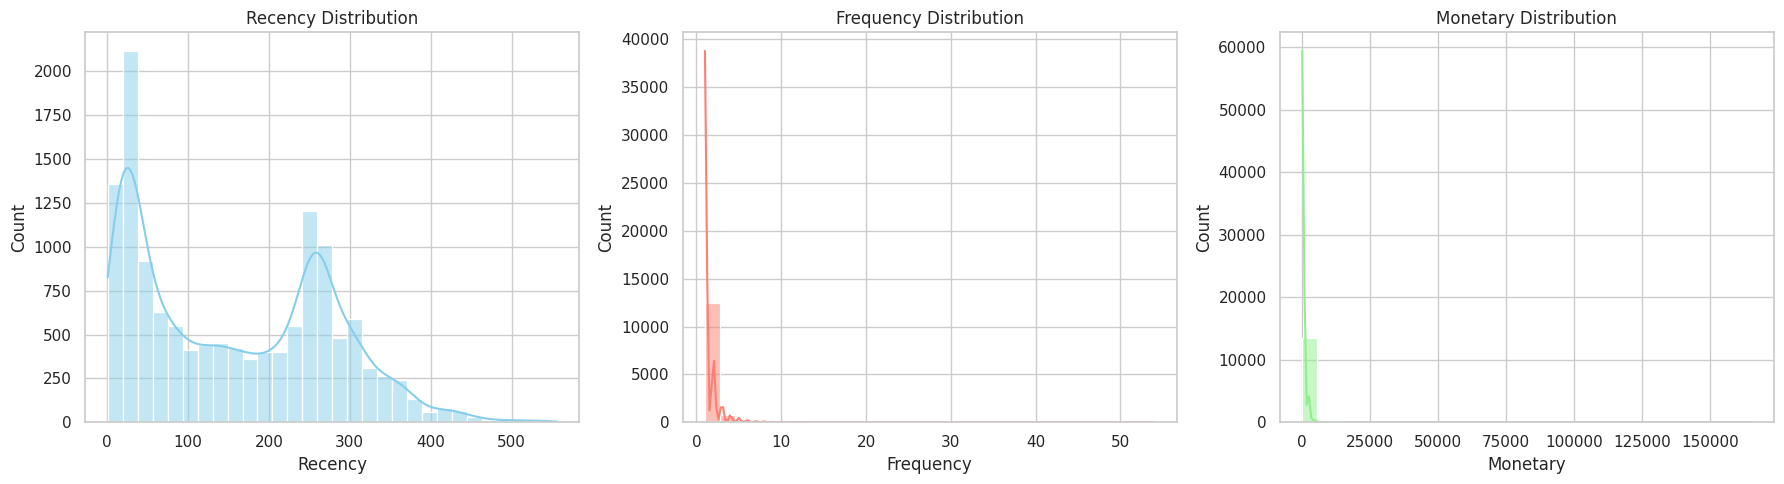

In [490]:
# Set up the style
sns.set(style="whitegrid")
plt.figure(figsize=(18, 5))

# Recency
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30, kde=True, color='skyblue')
plt.title('Recency Distribution')

# Frequency
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30, kde=True, color='salmon')
plt.title('Frequency Distribution')

# Monetary
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=30, kde=True, color='lightgreen')
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

---

## Phase 2: Customer Segmentation Using KMeans Clustering

### What We Did:
- Standardized RFM values using `StandardScaler`
- Determined optimal number of clusters using the Elbow Method (k = 4)
- Applied KMeans to segment customers into 4 distinct groups
- Mapped numeric clusters to intuitive labels:
  - **At-Risk**, **Recent Low-Spenders**, **Loyal Customers**, **VIP Customers**

### Visualizations Created:
- Histograms and boxplots for Recency, Frequency, and Monetary
- Scatter plots (R vs M, R vs F, F vs M)
- Heatmap of average RFM values per segment
- Pairplot of RFM features by segment
- Count of customers per segment

### Key Insights:
- **Most customers are at-risk or low-spend recent buyers**
- **VIPs are rare but incredibly valuable**
- Loyal customers offer great retention potential
- Visual patterns confirm meaningful cluster separation

### Output:
- Final RFM table with customer segments and labels added: `Segment` column


---

### 2a. **Standardized RFM Features**

After computing Recency, Frequency, and Monetary values, we applied **Z-score standardization** using `StandardScaler`. This scales each feature to have:

- **Mean = 0**
- **Standard deviation = 1**

#### Sample (Scaled) Rows:

| Recency | Frequency | Monetary |
|---------|-----------|----------|
| 2.086   | -0.305    | -0.218   |
| -1.120  | -0.305    | -0.179   |
| 1.192   | -0.305    | -0.140   |
| -0.168  | 0.467     | 0.206    |
| -1.145  | 2.012     | 0.316    |

### Interpretation:

- A **positive score** means the customer’s value is **above average** for that metric.
- A **negative score** means the value is **below average**.

#### Example:
- Row 0 has very **high recency** (2.08), meaning the customer is **inactive** (long time since last purchase).
- Row 4 has very **high frequency (2.01)** and above-average spend — this is a **likely VIP**.
- Row 1 has **recent activity** (`-1.12` Recency), but low frequency and spend — possibly a new customer.

 Standardization is essential for clustering methods like KMeans, which are sensitive to feature scale. This ensures **Recency**, **Frequency**, and **Monetary** are treated equally.


In [491]:
from sklearn.preprocessing import StandardScaler

# Create a copy for clustering
rfm_for_clustering = rfm[['Recency', 'Frequency', 'Monetary']].copy()

# Initialize and fit scaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_clustering)

# Convert back to DataFrame for easier analysis
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

rfm_scaled_df.head()

,Recency,Frequency,Monetary
0,2.086444,-0.305416,-0.218547
1,-1.120457,-0.305416,-0.179837
2,1.192854,-0.305416,-0.140387
3,-0.168408,0.467036,0.205593
4,-1.145511,2.011942,0.316073


---

### 2b. **Elbow Method for Optimal K**
**File:** `optimal_K.png`

- The "elbow" occurs at **k = 4**, suggesting 4 clusters capture customer behavior well.
- Beyond 4 clusters, WCSS reduces slowly — minimal benefit from adding more.

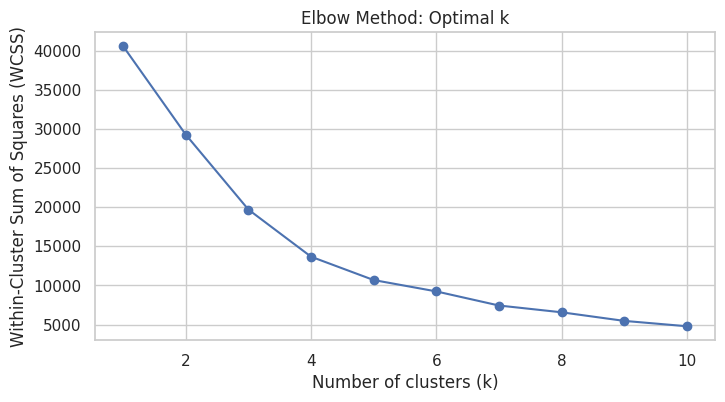

In [492]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method: Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

---

### 2c. **Cluster Assignments — Sample View**

After scaling the RFM features, we applied **KMeans clustering** with `k = 4`. Each customer is now assigned to one of four clusters based on their purchasing behavior.

#### Sample Rows:

| CustomerID | Recency | Frequency | Monetary | Cluster |
|------------|---------|-----------|----------|---------|
| 0          | 407     | 1         | 70.0     | 0       |
| 1          | 23      | 1         | 153.6    | 1       |
| 2          | 300     | 1         | 238.8    | 0       |
| 3          | 137     | 2         | 986.0    | 1       |
| 4          | 20      | 4         | 1224.6   | 3       |

### Interpretation:

- **Customer 4** has:
  - Very recent activity (`Recency = 20`)
  - High purchase frequency (`4`)
  - High spend (`₹1224.6`)
  - Assigned to **Cluster 3** → likely a **Loyal or VIP Customer**
  
- **Customer 0**:
  - High Recency (`407`) → hasn’t purchased in a long time
  - Assigned to **Cluster 0** → likely an **At-Risk or Churned Customer**

- **Clusters** capture behavior segments and serve as the foundation for:
  - Personalization
  - Campaign targeting
  - Predictive modeling


In [493]:
# Apply KMeans with optimal k
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
rfm_scaled_df['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

# Add back cluster info to original RFM
rfm['Cluster'] = rfm_scaled_df['Cluster']
rfm.head()

,CustomerID,Recency,Monetary,Frequency,Cluster,Segment
0,0,407,70.0,1,0,At-Risk
1,1,23,153.6,1,1,Recent Low-Spenders
2,2,300,238.8,1,0,At-Risk
3,3,137,986.0,2,1,Recent Low-Spenders
4,4,20,1224.6,4,3,Loyal Customers


---

### 2d. **Cluster Profiling Summary**

After clustering customers using KMeans, we calculated the average RFM metrics and customer count for each segment:

| Cluster | Recency ↓ | Frequency ↑ | Monetary ↑ | Num_Customers |
|---------|-----------|-------------|-------------|----------------|
| **2**   | 43.0      | 25.0        | 144,866.0   | 2              |
| **3**   | 75.0      | 5.8         | 2,970.5     | 490            |
| **0**   | 271.5     | 1.1         | 430.1       | 6,253          |
| **1**   | 57.6      | 1.3         | 427.0       | 6,776          |

### Interpretation:

- **Cluster 2 — VIP Customers** 
  - Only **2 customers**, but they buy frequently (**25 times**) and spend the most (~₹145K).
  - These are **ultra-valuable**, high-maintenance customers — consider premium loyalty benefits.

- **Cluster 3 — Loyal Customers** 
  - Good recency (75 days), solid frequency (~6), and strong spend (~₹2970).
  - Ideal base for **retention, cross-sell, or referral incentives**.

- **Cluster 1 — Recent Low-Spenders** 
  - Very recent purchases (~58 days), but low frequency and spend.
  - Likely **new or re-engaged** customers. Potential to **upsell or activate**.

- **Cluster 0 — At-Risk Customers** 
  - High recency (271 days), low frequency, and low spend.
  - These customers are **likely to churn** — need **win-back or reactivation** campaigns.

In [494]:
# Cluster profiling by computing mean RFM values per cluster
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Num_Customers'}).round(1)

cluster_profile.sort_values(by='Monetary', ascending=False)

,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
2,43.0,25.0,144866.0,2
3,75.0,5.8,2970.5,490
0,271.5,1.1,430.1,6253
1,57.6,1.3,427.0,6776


---

### 2e. **Final RFM Table with Cluster Segments**

After applying KMeans and mapping numeric clusters to human-readable labels, your final RFM dataset now includes a `Segment` column:

| CustomerID | Recency | Frequency | Monetary | Cluster | Segment              |
|------------|---------|-----------|----------|---------|-----------------------|
| 0          | 407     | 1         | 70.0     | 0       | At-Risk               |
| 1          | 23      | 1         | 153.6    | 1       | Recent Low-Spenders   |
| 2          | 300     | 1         | 238.8    | 0       | At-Risk               |
| 3          | 137     | 2         | 986.0    | 1       | Recent Low-Spenders   |
| 4          | 20      | 4         | 1224.6   | 3       | Loyal Customers       |

### Interpretation:

- **Cluster values** are numeric, but now translated into intuitive business labels via a mapping dictionary.
- This makes your dataset:
  - **Human-readable** and **marketing-ready**
  - Easy to use for personalized offers, retention, and future modeling
- You now have a **segmented customer base** with attached behavior profiles.

In [495]:
cluster_labels = {
    0: 'At-Risk',
    1: 'Recent Low-Spenders',
    2: 'VIP Customers',
    3: 'Loyal Customers'
}

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)
rfm.head()

,CustomerID,Recency,Monetary,Frequency,Cluster,Segment
0,0,407,70.0,1,0,At-Risk
1,1,23,153.6,1,1,Recent Low-Spenders
2,2,300,238.8,1,0,At-Risk
3,3,137,986.0,2,1,Recent Low-Spenders
4,4,20,1224.6,4,3,Loyal Customers


---

### 2f. **Recency vs. Monetary**
**File:** `customer_segments_recency_vs_monetary.png`

- **VIPs** are clustered in low-recency and high-monetary area (ideal).
- **At-Risk** customers are inactive with low spend.
- **Loyal Customers** show a spread across recency with moderate spend.

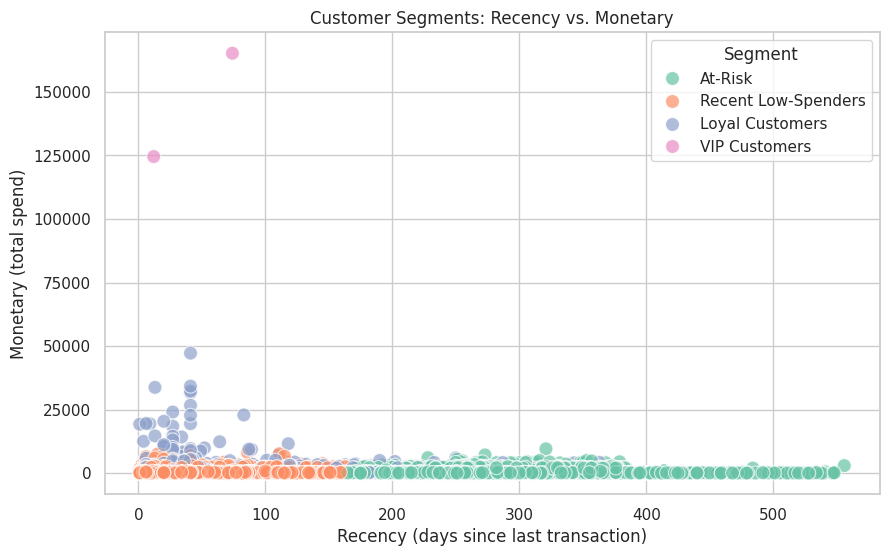

In [496]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm, 
    x='Recency', 
    y='Monetary', 
    hue='Segment', 
    palette='Set2',
    s=100,
    alpha=0.7
)
plt.title('Customer Segments: Recency vs. Monetary')
plt.xlabel('Recency (days since last transaction)')
plt.ylabel('Monetary (total spend)')
plt.legend(title='Segment')
plt.grid(True)
plt.show()

### 2g. **Frequency vs. Monetary**
**File:** `customer_segments_frequency_vs_monetary.png`

- **VIP Customers**: High frequency and extremely high spend.
- **Loyal Customers**: Consistent and moderate.
- **Low frequency & low spend** segments dominate the base — ideal for campaigns.

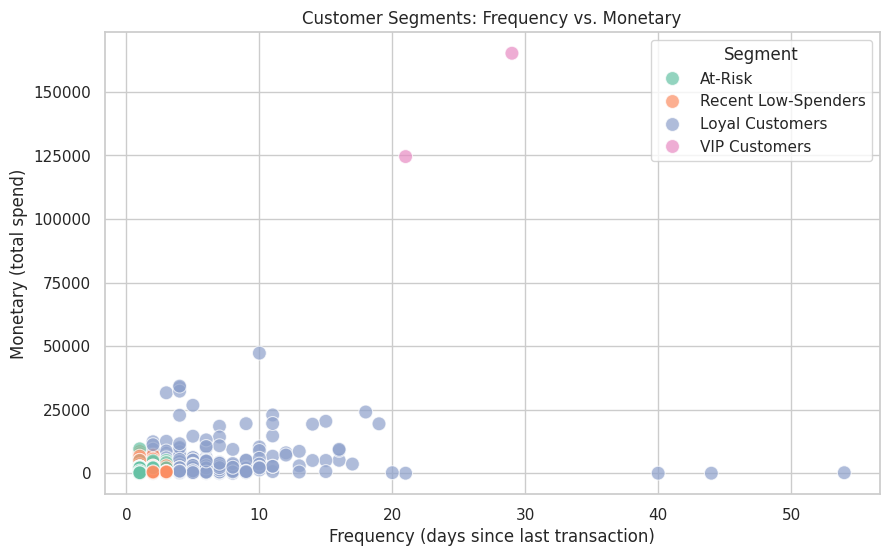

In [497]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm, 
    x='Frequency', 
    y='Monetary', 
    hue='Segment', 
    palette='Set2',
    s=100,
    alpha=0.7
)
plt.title('Customer Segments: Frequency vs. Monetary')
plt.xlabel('Frequency (days since last transaction)')
plt.ylabel('Monetary (total spend)')
plt.legend(title='Segment')
plt.grid(True)
plt.show()

---

### 2h. **Recency vs. Frequency**
**File:** `customer_segments_recency_vs_frequency.png`

- **VIPs** and **Loyal Customers** are in low-recency and high-frequency zones.
- **Recent Low-Spenders** are promising — recent but not frequent.
- **At-Risk** customers are both infrequent and long-inactive.

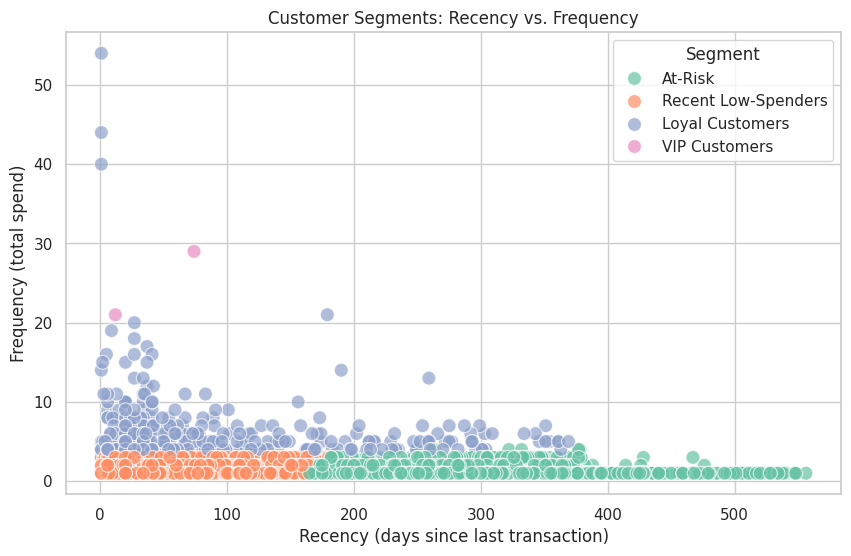

In [498]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm, 
    x='Recency', 
    y='Frequency', 
    hue='Segment', 
    palette='Set2',
    s=100,
    alpha=0.7
)
plt.title('Customer Segments: Recency vs. Frequency')
plt.xlabel('Recency (days since last transaction)')
plt.ylabel('Frequency (total spend)')
plt.legend(title='Segment')
plt.grid(True)
plt.show()

---

### 2i. **Number of Customers per Segment**
**File:** `Number_of_customers_per_segment.png`

- **Recent Low-Spenders** make up the **largest segment** — these are customers who bought recently but haven’t spent much. Ideal for upsell and personalization.
- **At-Risk Customers** form the second-largest group — they are inactive or slipping away, requiring **re-engagement campaigns**.
- **Loyal Customers** are relatively few but likely **profitable** due to repeated behavior.
- **VIP Customers** are the rarest — but have the **highest value per individual**, meaning they deserve **exclusive treatment or loyalty perks**.

Insight: Most customers are either new or fading. The true opportunity lies in turning Low-Spenders into Loyalists, and retaining Loyalists before they churn.

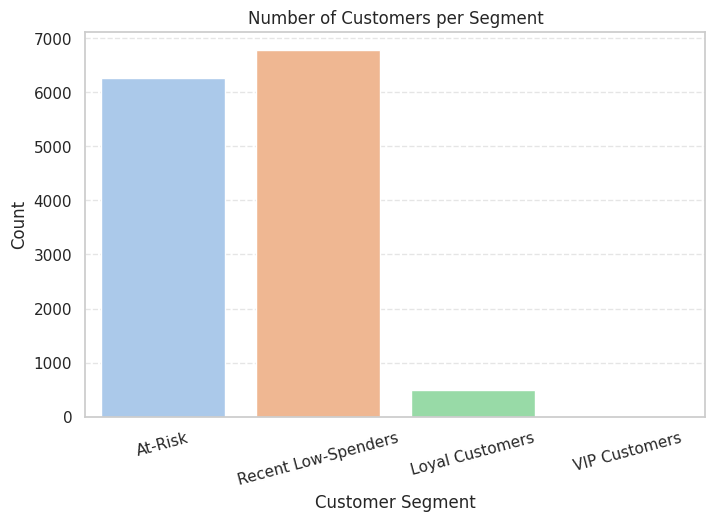

In [499]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=rfm,
    x='Segment',
    hue='Segment',  # <- assigning hue to avoid future deprecation
    palette='pastel',
    dodge=False,     # prevents double bars
    legend=False     # prevents duplicate legend
)
plt.title('Number of Customers per Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Count')
plt.xticks(rotation=15)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

---

### 2j. **Monetary Value Distribution by Segment**
**File:** `monetary_value_distribution_by_segment.png`

- **VIP Customers** show extreme monetary value — highest spenders.
- **At-Risk** and **Recent Low-Spenders** contribute very little.
- **Loyal Customers** have decent and consistent spend.

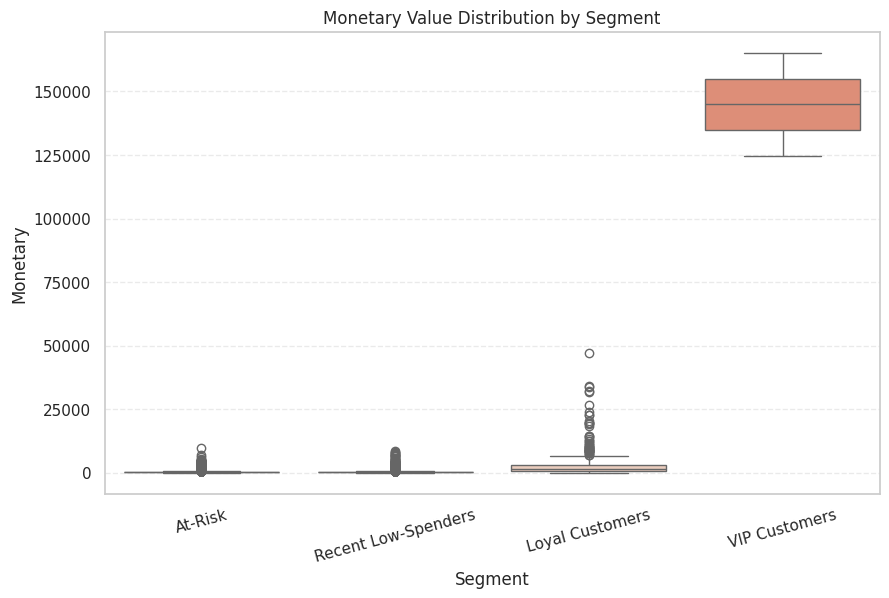

In [500]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=rfm,
    x='Segment',
    y='Monetary',
    hue='Segment',         
    palette='coolwarm',
    dodge=False,            
    legend=False          
)
plt.title('Monetary Value Distribution by Segment')
plt.xlabel('Segment')
plt.ylabel('Monetary')
plt.xticks(rotation=15)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.show()

---

### 2k. **Pairplot of RFM Features by Segment**
**File:** `pairpot_of_rfm_features_by_segment.png`

- Provides a multi-dimensional view of how **Recency**, **Frequency**, and **Monetary** relate.
- **VIP Customers** stand out across all axes — low recency, high frequency, high monetary.
- **Loyal Customers** show strong frequency and moderate monetary values with good recency.
- **Recent Low-Spenders** are tightly packed in low frequency and monetary zones but with low recency — a key **growth opportunity**.
- **At-Risk Customers** cluster in high recency (inactive), low frequency, and low spend — needing re-engagement.
- The diagonal `kde` plots show overall feature distribution; the scatter plots reveal how well the clusters separate.

This chart visually validates your clusters and highlights how they occupy different zones in the RFM space.

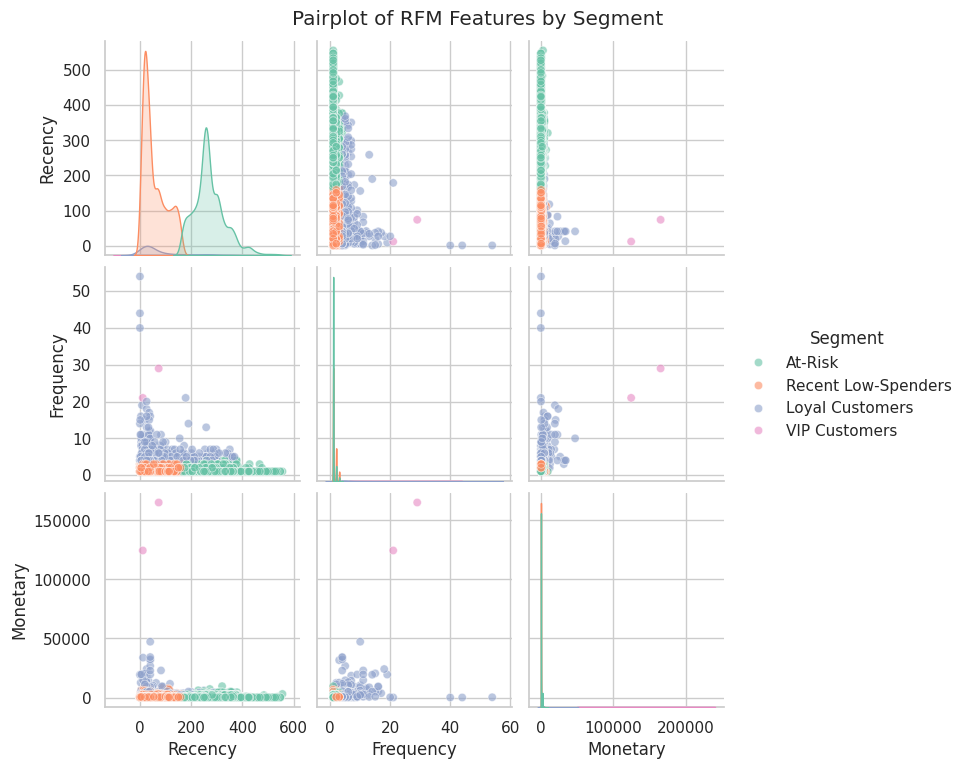

In [501]:
sns.set(style="whitegrid")

pair = sns.pairplot(
    data=rfm,  # or rfm_sample
    vars=['Recency', 'Frequency', 'Monetary'],
    hue='Segment',
    palette='Set2',
    diag_kind='kde',
    plot_kws={'alpha': 0.6}
)
pair.fig.suptitle("Pairplot of RFM Features by Segment", y=1.02)
plt.show()


---

### 2l. **Heatmap of Average RFM per Segment**
**File:** `average_rfm_values_by_segment.png`

- **VIPs**: Highest in frequency and monetary, lowest in recency.
- **At-Risk**: Highest recency, lowest everything else.
- **Loyal Customers**: Balanced performance.
- **Recent Low-Spenders**: Opportunity for upselling and nurturing.

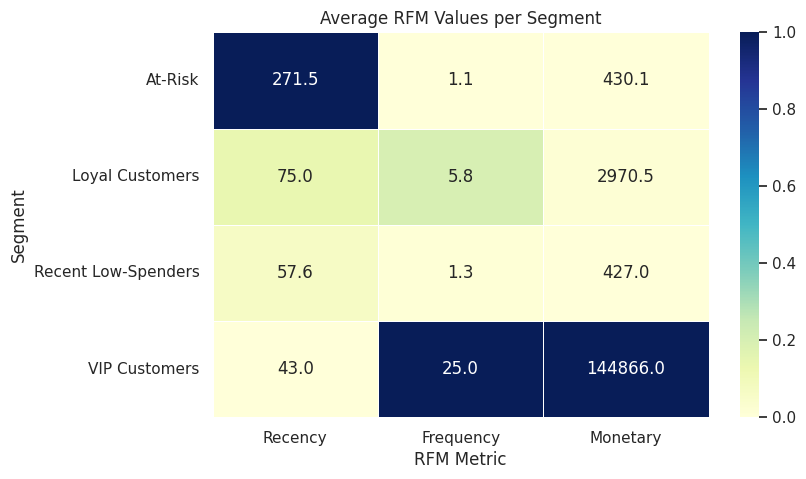

In [502]:
# Prepare data: average RFM values per segment
rfm_heatmap_data = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

# Normalize the values for better color contrast (optional)
rfm_normalized = rfm_heatmap_data.copy()
for col in rfm_normalized.columns:
    rfm_normalized[col] = (rfm_normalized[col] - rfm_normalized[col].min()) / (rfm_normalized[col].max() - rfm_normalized[col].min())

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(rfm_normalized, annot=rfm_heatmap_data, fmt='.1f', cmap='YlGnBu', linewidths=0.5)
plt.title("Average RFM Values per Segment")
plt.ylabel("Segment")
plt.xlabel("RFM Metric")
plt.show()

In [503]:
# Save final enriched RFM dataset for Phase 3
rfm.to_csv('../data/processed/rfm_table.csv', index=False)

---